In [2]:
# to get automatic reloading
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.plots import *
from fastai.io import get_data
from fastai.conv_learner import *

In [5]:
PATH = "data/emotionet/"
IMGP = "imgs"
csv_path = f"{PATH}uniqueaus6_12.csv"

In [6]:
n = len(list(open(csv_path)))-1
val_idxs = get_cv_idxs(n)
n, len(val_idxs)

(355, 71)

In [7]:
sz = 224
f_model = resnet34
bs = 64

In [8]:
tfms = tfms_from_model(f_model, sz)
data = ImageClassifierData.from_csv(PATH,IMGP,csv_path,bs=bs,tfms=tfms,val_idxs=val_idxs)
learn = ConvLearner.pretrained(f_model, data, precompute=True)

100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


In [9]:
learn.fit(0.01,2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.924877   0.742622   0.549296  
    1      0.802965   0.669008   0.676056        



/home/sohaib/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[array([0.66901]), 0.676056338867671]

In [17]:
bs=8
data = ImageClassifierData.from_csv(PATH,IMGP,csv_path,bs=bs,tfms=tfms,val_idxs=val_idxs)
learn = ConvLearner.pretrained(f_model,data,precompute=True)
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/36 [00:00<?, ?it/s, loss=3.35] 


/home/sohaib/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


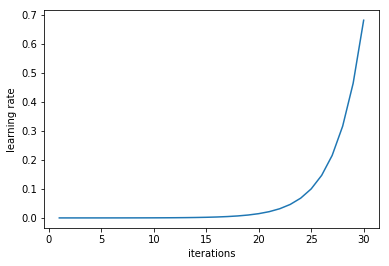

In [18]:
learn.sched.plot_lr()

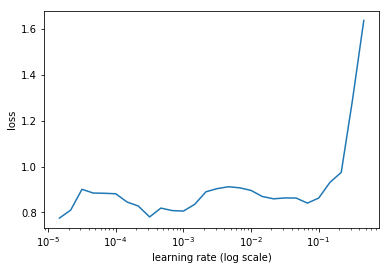

In [19]:
learn.sched.plot(n_skip=1, n_skip_end=1)

**AUGMENT THE DATA**

In [20]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [25]:
def get_augs():
    data = ImageClassifierData.from_csv(PATH, IMGP, csv_path, bs=2, tfms=tfms)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [26]:
ims = np.stack([get_augs() for i in range(6)])

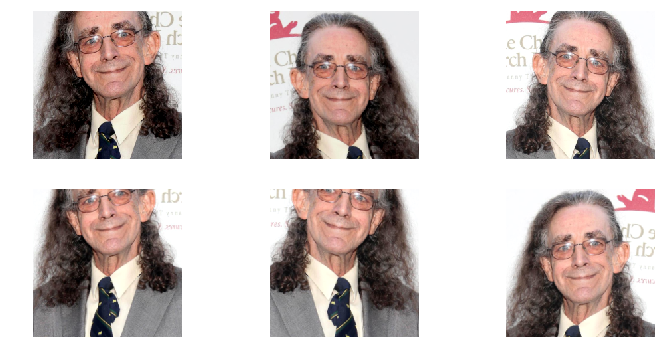

In [27]:
plots(ims, rows=2)

In [29]:
data = ImageClassifierData.from_csv(PATH, IMGP, csv_path, bs=bs, tfms=tfms)
learn = ConvLearner.pretrained(f_model, data, precompute=True)

In [32]:
learn.fit(1e-4, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 11%|█         | 4/36 [00:00<00:02, 12.85it/s, loss=1.06] 

/home/sohaib/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch      trn_loss   val_loss   accuracy                 
    0      1.332098   1.653561   0.577465  



[array([1.65356]), 0.5774647912509004]

In [33]:
learn.precompute=False

In [34]:
learn.fit(1e-4,3,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 17%|█▋        | 6/36 [00:00<00:01, 17.63it/s, loss=1.64]

/home/sohaib/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch      trn_loss   val_loss   accuracy                 
    0      1.271021   1.742495   0.605634  
    1      1.221278   1.571651   0.577465                 
    2      1.168786   1.538474   0.56338                  



[array([1.53847]), 0.5633802821098919]

In [35]:
learn.unfreeze()

In [36]:
lr = np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  8%|▊         | 3/36 [00:00<00:03, 10.19it/s, loss=1.22]

/home/sohaib/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch      trn_loss   val_loss   accuracy                 
    0      1.111425   1.204553   0.549296  
    1      1.202257   0.712168   0.676056                  
    2      0.940938   0.971996   0.619718                  
    3      0.941659   1.116645   0.676056                  
    4      0.89408    1.401791   0.690141                  
    5      0.78476    1.105061   0.71831                   
    6      0.670485   0.993067   0.690141                  



[array([0.99307]), 0.6901408467494267]

In [48]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

/home/sohaib/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.7746478873239436

In [55]:
data.classes

['AU12', 'AU6']

[[34  6]
 [10 21]]


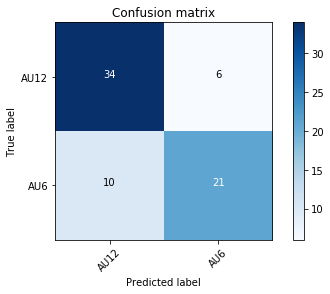

In [49]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [50]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most incorrect AU12 Lips


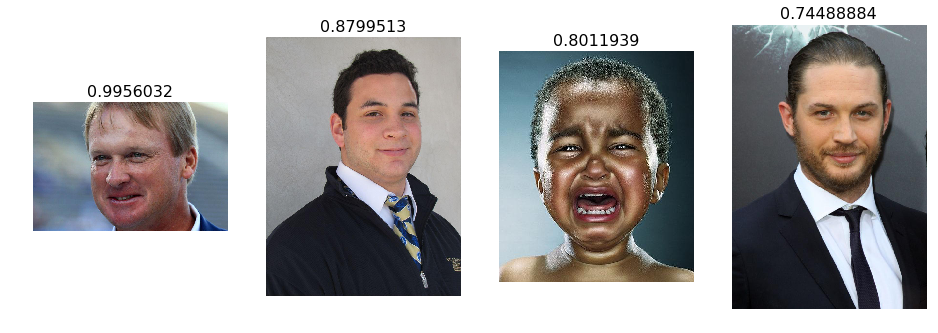

In [58]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect AU12 Lips")

Most incorrect AU6 cheeck


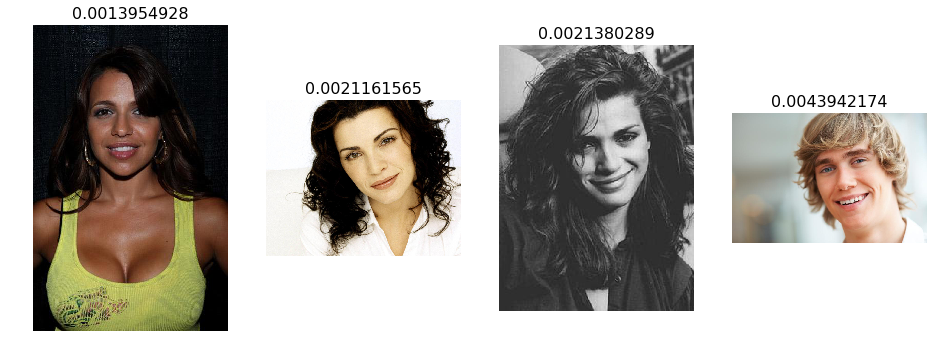

In [59]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect AU6 cheeck")

Most correct AU12 Lips


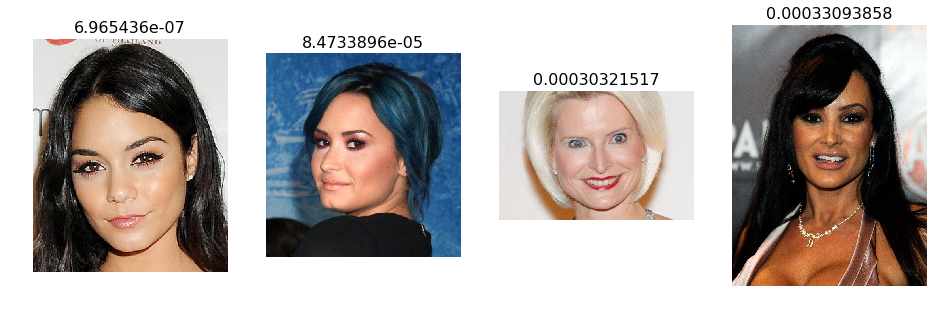

In [60]:
plot_val_with_title(most_by_correct(0, True), "Most correct AU12 Lips")

Most correct AU6 cheeck


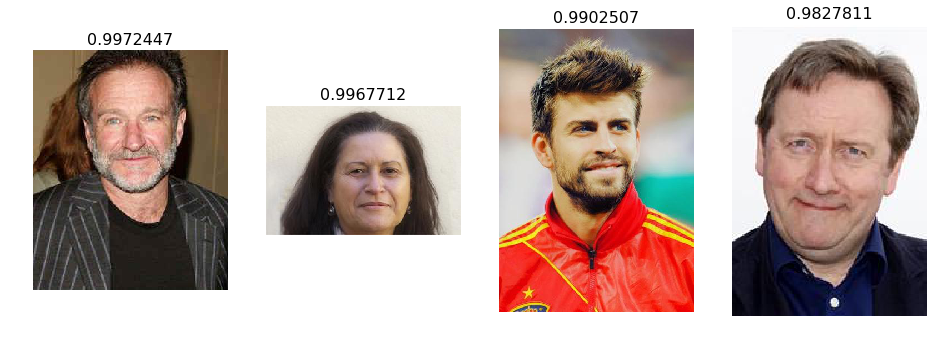

In [61]:
plot_val_with_title(most_by_correct(1, True), "Most correct AU6 cheeck")

In [62]:
learn.summary()

/home/sohaib/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 56